In [31]:
import warnings
from copy import copy

import numpy as np
from matplotlib import pyplot as plt

from algorithm.supervised.gaussian_process_detector import GaussianProcessAD
from data_preparation.data_cleaning.smooth import DataSmooth
from data_preparation.data_cleaning.transform import DataTransform
from example.algorithm.data_loader import data_loader

%matplotlib inline

## Anomaly Detection based on Gaussian Process

首先，我们不考虑数据的周期属性，在选取训练数据时，直接采用当前时间前过去N个窗口数据进行训练，而并没有选取1天前、7天前、14天前以及1月前的窗口数据


### Data smooth

数据中的异常点会干扰高斯过程的拟合，因此需要对训练数据做数据平滑处理


No handles with labels found to put in legend.


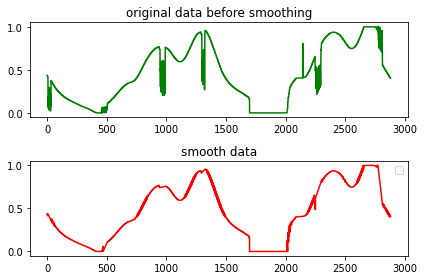

In [32]:
original_data = data_loader('jitter', 'ja_set_online.csv')

# 数据平滑处理
smooth_data = copy(original_data)
ds = DataSmooth(smooth_data, mode='Diff')
smooth_data = ds.run()

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(original_data, c='g')
plt.title('original data before smoothing')

plt.subplot(2, 1, 2)
plt.plot(smooth_data, 'r')
plt.title('smooth data')
plt.legend(loc=0)
plt.tight_layout()

### Gaussian Process Detector

对平滑数据进行训练，并测试原始数据是否存在异常

In [33]:
def data_transform(x):
    params = {'window': 15}
    dt = DataTransform(x, mode='SlideWindow', **params)
    return dt.run()

def gaussian_detector(x, y, x_star):
    gp_ad = GaussianProcessAD(x, y)
    gp_ad.fit()
    return gp_ad.predict(x_star)


def plot_gp_ad(x_train, y_train, y_test, n=200):
    sample_size = 180
    x_original = np.array(range(n))

    y_lower = []
    y_higher = []
    y_original = []
    abnormal_index = []

    size = x_train.shape[0]
    for i in range(size - n, size):
        x, y = x_train[i - sample_size:i], y_train[i - sample_size:i]
        x_star = np.asarray([x_train[i]])
        y_predict, lower, higher = gaussian_detector(x, y, x_star)
        y_star = y_test[i]

        PE = np.abs((y_predict[0] - y_star) / (y_star + 1e-6))
        y_lower.append(lower[0])
        y_higher.append(higher[0])
        y_original.append(y_star)

        index = i - (size - n)
        if PE > 0.01 and (y_star < lower[0] or y_star > higher[0]):
            abnormal_index.append(index)

        if i % 20 == 0:
            print('Training Process: {:.2%} ({}/{})'.format(index/200, index, 200))

    plt.figure()
    plt.plot(x_original, y_original, c='b', label='original data')
    plt.fill_between(x_original, y_lower, y_higher, alpha=0.2)
    plt.scatter(x_original[abnormal_index], np.asarray(y_original)[abnormal_index], color='r', s=40, marker='*')
    plt.title('Gaussian Process Detector')
    plt.legend(loc=0)
    plt.tight_layout()


Training Process: 7.00% (14/200)
Training Process: 17.00% (34/200)
Training Process: 27.00% (54/200)
Training Process: 37.00% (74/200)
Training Process: 47.00% (94/200)
Training Process: 57.00% (114/200)
Training Process: 67.00% (134/200)
Training Process: 77.00% (154/200)
Training Process: 87.00% (174/200)
Training Process: 97.00% (194/200)


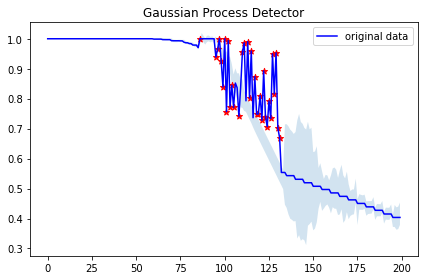

In [34]:
# train/test data
x_train, y_train = data_transform(smooth_data)
x_test, y_test = data_transform(original_data)


# 选取最后200个数据点进行效果验证
warnings.filterwarnings("ignore")
plot_gp_ad(x_train, y_train, y_test, n=200)
